# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in NumPy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [315]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        
        for input, grad in self.grad_fn():
            # print("input: ", input)
            # print("grad: ", grad)
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])
    
    def tanh(self):
        return Var((exp(2*self.v) - 1) / (exp(2*self.v) + 1), lambda: [(self, 1 - (exp(2*self.v) - 1) / (exp(2*self.v) + 1)**2)])
    
    def sigmoid(self):
        return Var(1 / (1 + exp(-self.v)), lambda: [(self, exp(-self.v) / (1 + exp(-self.v))**2)])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

A few examples illustrate how we can use this:

In [316]:
a = Var(3.0)
# print(a.grad_fn())
b = Var(5.0)
# print(b.grad_fn())
f = a * b
# print(f.grad_fn())
# print(f.grad)
f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [317]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

<h2 style="color: white;">Solution a)</h2>

Gradient Calculation : when we call f.backward(), it calculates the gradients for all variables involved. 

For the first line of the output : Var(v=3.000, grad = 14.0000) means a = 3 and its gradient is 14. This is because $f$ depends on $a$ through both $c = a * b$ and $e = a * d$.

Therefore, the gradient of $f$ with respect to $a$ is the sum of the two contributions : 
\begin{align}
\frac{\partial f}{\partial a} &= \frac{\partial f }{\partial c } . \frac{\partial c }{\partial a } + \frac{\partial f }{\partial e } . \frac{\partial e }{\partial a} \\
&= b + d = 14
\end{align}

Again, for the second line : Var(v=5.000, grad = 3.0000) means b = 5 and its gradient is 3. The reason is that b only appears in c = a * b, so the gradient of f with respect to b is :
\begin{align}
\frac{\partial f}{\partial b} &= \frac{\partial f }{\partial c } . \frac{\partial c }{\partial b } \\
&= a = 3
\end{align}

Similarily, the gradient of f with respect to $c$, $d$, $e$, $f$ is as follows: 
\begin{align}
\frac{\partial f}{\partial c} &= 1 \\
\frac{\partial f}{\partial d} &= \frac{\partial f }{\partial e } . \frac{\partial e }{\partial d } = a = 3 \\
\frac{\partial f}{\partial e} &= 1 \\
\frac{\partial f}{\partial f} &= 1 \\
\end{align}

Overall, the result Var(v,grad) tells you the value of that defined object, and grad tells you how much the factor in which the value has changed. 

And the code is calculating the gradients of the expression $f = (a * b) + (a * d)$ with respect to the variables $a,b,c,d,e$ and $f$. More specifically, $a,b,d$ are the independent variables as the input variables, and $c,e,f$ are the dependent ones.

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

In [318]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

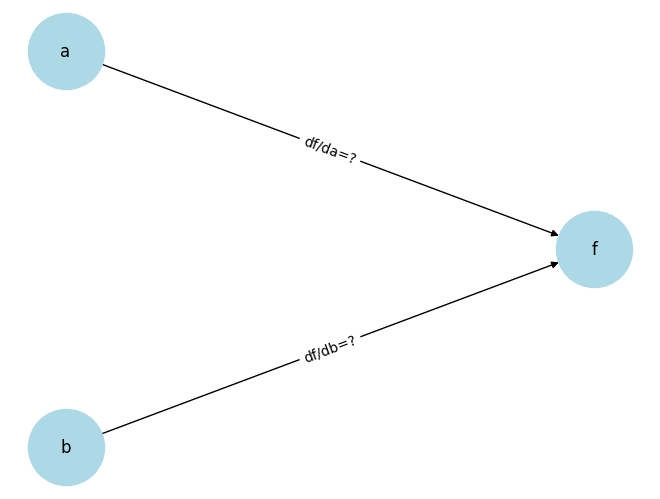

In [319]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=?')
G.add_edge('b', 'f', label='df/db=?')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

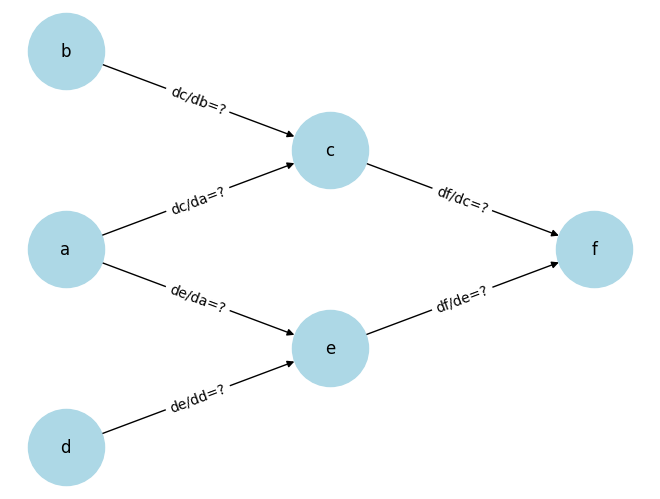

In [320]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=?')
G.add_edge('b', 'c', label='dc/db=?')
G.add_edge('a', 'e', label='de/da=?')
G.add_edge('d', 'e', label='de/dd=?')
G.add_edge('c', 'f', label='df/dc=?')
G.add_edge('e', 'f', label='df/de=?')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

<h2 style="color: white;">Solution b)</h2>

<h3 style="color: white;">answer (1)</h3>

In the graph 1, define f = a * b, then we have :
\begin{align}
\frac{\partial f}{\partial a} = b \\
\frac{\partial f}{\partial b} = a 
\end{align}


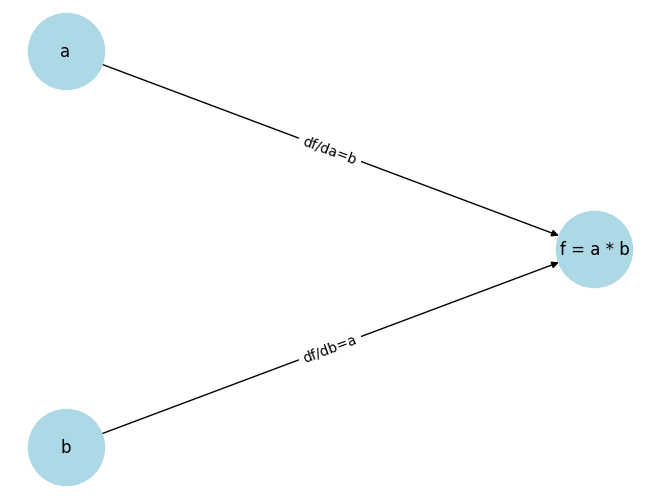

In [321]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=b')
G.add_edge('b', 'f', label='df/db=a')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=False, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw node labels
node_labels = {'a': 'a', 'b': 'b', 'f': 'f = a * b'}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


In the graph 2:

for $c = a * b$, the partial derviativate are :
\begin{align}
\frac{\partial c}{\partial a} = b \\
\frac{\partial c}{\partial b} = a 
\end{align}

for $e = a * d$, the partial derviativate are :
\begin{align}
\frac{\partial e}{\partial a} = d \\
\frac{\partial e}{\partial d} = a 
\end{align}

for $f = c + e$, the partial derviativate are :
\begin{align}
\frac{\partial f}{\partial c} = 1 \\
\frac{\partial f}{\partial e} = 1 
\end{align}

Finally, we have :
\begin{align}
& \frac{\partial f}{\partial a} = \frac{\partial f}{\partial c} . \frac{\partial c}{\partial a} + \frac{\partial f}{\partial e} . \frac{\partial e}{\partial a}= b + d \\
& \frac{\partial f}{\partial b} = \frac{\partial f}{\partial c} . \frac{\partial c}{\partial b} + \frac{\partial f}{\partial e} . \frac{\partial e}{\partial b}=  a 
\end{align}

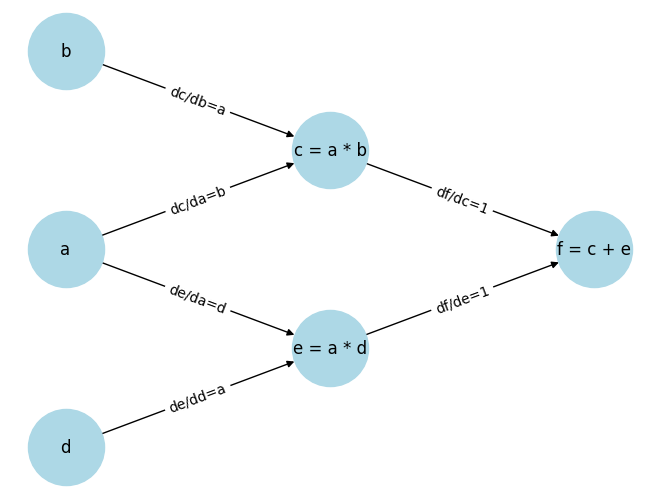

In [322]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=b')
G.add_edge('b', 'c', label='dc/db=a')
G.add_edge('a', 'e', label='de/da=d')
G.add_edge('d', 'e', label='de/dd=a')
G.add_edge('c', 'f', label='df/dc=1')
G.add_edge('e', 'f', label='df/de=1')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=False, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw node labels
node_labels = {'a': 'a', 'b': 'b', 'c': 'c = a * b', 'd': 'd', 'e': 'e = a * d','f': 'f = c + e'}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

<h3 style="color: white;">answer (2)</h3>

When defining the expression f = (a * b) + (a * d), the schematic data structure could be as follows (take the example value from exercise 1):

1. Variables : 

    a : (value : 3.0, grad = 0.0, grad_fn link to both c = a * b and e = a * d)

    b : (value : 5.0, grad = 0.0, grad_fn link to c = a * b)

    d : (value : 9.0, grad = 0.0, grad_fn link to e = a * d)
2. Hidden layer : 

    c = a * b : (value : 15.0, grad = 0.0, grad_fn : $\frac{\partial c}{\partial a} = b, \frac{\partial c}{\partial b} = a$)

    e = a * d : (value : 27.0, grad = 0.0, grad_fn : $\frac{\partial e}{\partial a} = d, \frac{\partial e}{\partial d} = a$)

3. Final result :
    f = c + e : (value : 42.0, grad = 0.0, grad_fn : $\frac{\partial f}{\partial c} = 1, \frac{\partial f}{\partial e} = 1$)

Each variable is store as a Var object with its value, initial gradient, and gradient function used for backpropagation.


<h3 style="color: white;">answer (3)</h3>

Manually executing the backward function for f = (a * b) + (a * d) : 

1. We start with f :

    $\frac{\partial f}{\partial f} = 1$

    since f = c + e, propagate gradients back to c and e

    $\frac{\partial f}{\partial c} = 1$, $\frac{\partial f}{\partial e} = 1$

2. For c = a * b :

    $\frac{\partial f}{\partial a} = b$, $\frac{\partial f}{\partial b} = a$

    Gradients : $grad^{(c)}_{a} = 5, gard_b = 3$

3. For e = a * d : 

    $\frac{\partial f}{\partial a} = d$, $\frac{\partial f}{\partial d} = a$

    Gradients : $grad^{(e)}_{a} = 9, gard_d = 3$

4. Sum the contributions from both term : $gard_a$ = $grad^{(c)}_{a}$ + $grad^{(e)}_{a}$ = 14

Final gradients : 
\begin{align}
& grad_a = 14\\
& grad_b = 3\\
& grad_d = 3
\end{align}
This confirms that the backward function correctly computes the gradients.

<h3 style="color: white;">answer (4)</h3>

The sequence of calls to backprop is :

1. f.backward() is called and then f.backprop(1.0) is called.
2. f.grad is set to $\frac{\partial f}{\partial f} = 1$
3. since f is defined as c + e, which is stored in f.grad_fn. 
4. c.backdrop(1.0) is called : 

    4.1 the backdrop call move on to c = a * b with the chain rule : 

    call a.backdrop(b) becasue $\frac{\partial c}{\partial a} = b = 5$

    call b.backdrop(a) because $\frac{\partial c}{\partial b} = a = 3$

5. e.backdrop(1.0) is called : 

    5.1 the backdrop call move on to e = a * d with the chain rule :
    
    call a.backdrop(d) because $\frac{\partial e}{\partial a} = d = 9$

    call d.backdrop(a) because $\frac{\partial e}{\partial d} = a = 3$

In conclusion : 

First run  : f.backdrop(1.0)

Second run : c.backdrop(1.0) , e.backdrop(1.0)

Third run  : a.backdrop(b) , b.backdrop(a) 

Fourth run : a.backdrop(d) , d.backdrop(a)


## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [323]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


<h2 style="color: white;">Solution c)</h2>

The gradient is multiplied by 2, because the same gradients are calculated again, and are added back to the variable gradient rather than being reset. If we run this cell for multiple times without clearing all outputs will cause the gradients to keep increasing. 

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [324]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)
print("\n")
for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


<h2 style="color: white;">Solution d)</h2>

Firstly, when a is redefined, the value and gradient will be initialized, but the previous value of a is still stored within the function f, and can be accessed through the grad_fn() calls. 

Then, when f.backprop(-1.0) is executed, it results in reducing the gradient values as shown in the above results. This means that if we use backdrop(-1.0), it effectively reverses one step of the backpropagation by subtracting the previouly accumulated gradients.

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [325]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """

    fa_da = 0           # <- Insert correct expression
    fa = 0               # <- Insert correct expression

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference())

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
0.0


<h2 style="color: white;">Solution e)</h2>

Check the following code

In [326]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(a,da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    if isinstance(a, int):
        a = float(a)
        
    fa_da = f_function(a + da)[2].v           # <- Insert correct expression
    fa = f_function(a)[2].v               # <- Insert correct expression

    finite_difference = (fa_da - fa) / da
    
    return finite_difference

print(finite_difference(a=3.0))

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
5.000000413701855


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [327]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [328]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [329]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

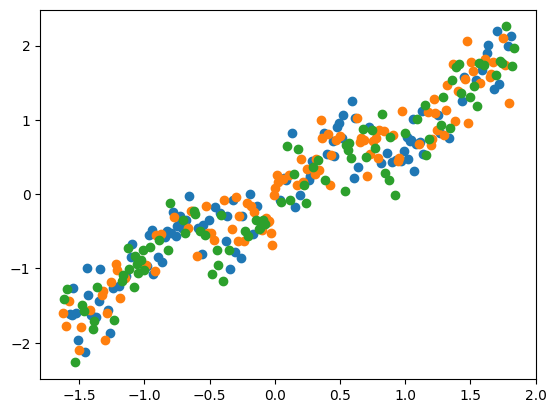

In [330]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [331]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [332]:
class Initializer:

  # def init_weights(self, n_in, n_out):
  #   raise NotImplementedError

  # def init_bias(self, n_out):
  #   raise NotImplementedError
  
  def __init__(self, init_type='glorot', activation='tanh'):
        """
        init_type: str, 'glorot' or 'he' to specify the type of initialization.
        activation: str, the activation function to use, e.g., 'tanh' or 'relu'.
        """
        self.init_type = init_type
        self.activation = activation

  def init_weights(self, n_in, n_out):
      """
      Initialize weights based on Glorot or He initialization.
      """
      if self.init_type == 'glorot':
          # Glorot initialization
          if self.activation == 'tanh':
              std = np.sqrt(2 / (n_in + n_out))  # Glorot for tanh
          elif self.activation == 'relu':
              std = np.sqrt(2 / (n_in + n_out))  # Glorot for ReLU
          else:
              raise ValueError(f"Unsupported activation function: {self.activation}")
      
      elif self.init_type == 'he':
          # He initialization
          if self.activation == 'relu':
              std = np.sqrt(2 / n_in)  # He for ReLU
          else:
              raise ValueError(f"He initialization is typically used with ReLU.")
      else:
          raise ValueError(f"Unsupported initialization type: {self.init_type}")
      
      return np.random.normal(0, std, (n_in, n_out))  # Return weights with proper distribution

  def init_bias(self, n_out):
      """
      Initialize bias to zero or another value.
      """
      return np.zeros(n_out)  # Biases are typically initialized to zero
  

In [333]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [334]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            # node = Var(0.0) # <- Insert code
            node = self.bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                # node += Var(0.0)  # <- Insert code
                node += single_input[i] * weights[i][j]
            node = self.act_fn(node)
            out.append(node)

        return out
    
    def print_parameters(self):
        n_out = len(self.weights[0])
        n_in = len(self.weights)
        params = self.parameters()
        description = [[f'Weight from input {j} to node {i}: {params[n_out * j + i]} and bias {params[-(n_out-i)]}' for i in range(n_out)] for j in range(n_in)]
        return sum(description, [])

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

<h2 style="color: white;">Solution f)</h2>


The following code has been implemented in the previous Var class: 
```python 
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])

    def tanh(self):
        return Var((exp(2*self.v) - 1) / (exp(2*self.v) + 1), lambda: [(self, 1 - (exp(2*self.v) - 1) / (exp(2*self.v) + 1)**2)])

    def sigmoid(self):
        return Var(1 / (1 + exp(-self.v)), lambda: [(self, exp(-self.v) / (1 + exp(-self.v))**2)])
```

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [335]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0050, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0012, grad=0.0000)], [Var(v=-0.0052, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0032, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0037, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0024, grad=0.0000)], [Var(v=-0.0011, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0014, grad=0.0000)], [Var(v=-0.0038, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0047, grad=0.0000)], [Var(v=0.0000, grad=0.0000)], [Var(v=-0.0041, grad=0.0000)]

<h2 style="color: white;">Solution g)</h2>

The following code has been implemented in previos DenseLayer Class :

```python
    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            # node = Var(0.0) # <- Insert code
            node = self.bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                # node += Var(0.0)  # <- Insert code
                node += single_input[i] * weights[i][j]
            node = self.act_fn(node)
            out.append(node)

        return out
```

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

<h2 style="color: white;">Solution h)</h2>

The following code snippet has been implemented in previos DenseLayer Class :
```python
def print_parameters(self):
    n_out = len(self.weights[0])
    n_in = len(self.weights)
    params = self.parameters()
    description = [[f'Weight from input {j} to node {i}: {params[n_out * j + i]} and bias {params[-(n_out-i)]}' for i in range(n_out)] for j in range(n_in)]
    return sum(description, [])
```

And this following code prints all the parameters in the neural network, assuming the input is of the format of the previously used definition of NN, which is a list of DenseLayer class calls.

In [336]:
# Insert code here and in the DenseLayer class
def print_NN(NN):
  for i, j in enumerate(NN):
    if i==0:
      print(f'Layer {i} (input) to {i+1}:')
    elif i==len(NN)-1:
      print(f'Layer {i} to {i+1} (output):')
    else:
      print(f'Layer {i} to {i+1}:')
    for x in j.print_parameters():
        print(x)

print_NN(NN=NN)

Layer 0 (input) to 1:
Weight from input 0 to node 0: Var(v=-0.0439, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 1: Var(v=-0.1326, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 2: Var(v=-0.1517, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 3: Var(v=-0.0935, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 0 to node 4: Var(v=-0.0754, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Layer 1 to 2 (output):
Weight from input 0 to node 0: Var(v=0.0035, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 1 to node 0: Var(v=-0.0717, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 2 to node 0: Var(v=0.0908, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 3 to node 0: Var(v=-0.0373, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)
Weight from input 4 to node 0: Var(v=-0.0563, grad=0.0000) and bias Var(v=0.0000, grad=0.0000)


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

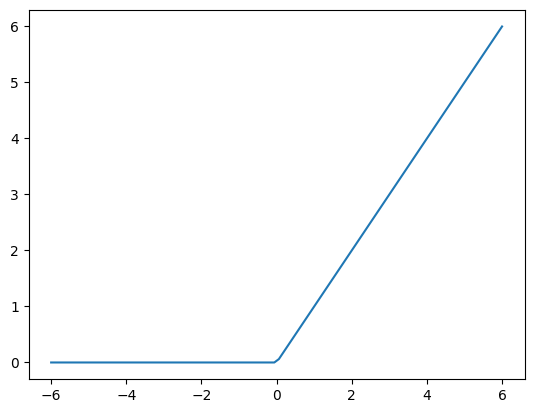

In [337]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

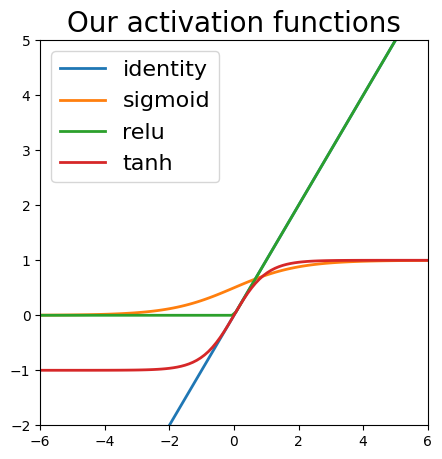

In [338]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

<h2 style="color: white;">Solution i)</h2>

The following code has been implemented in the previous Initializer class:

```python
class Initializer:
  
  def __init__(self, init_type='glorot', activation='tanh'):
        """
        init_type: str, 'glorot' or 'he' to specify the type of initialization.
        activation: str, the activation function to use, e.g., 'tanh' or 'relu'.
        """
        self.init_type = init_type
        self.activation = activation

  def init_weights(self, n_in, n_out):
      """
      Initialize weights based on Glorot or He initialization.
      """
      if self.init_type == 'glorot':
          # Glorot initialization
          if self.activation == 'tanh':
              std = np.sqrt(2 / (n_in + n_out))  # Glorot for tanh
          elif self.activation == 'relu':
              std = np.sqrt(2 / (n_in + n_out))  # Glorot for ReLU
          else:
              raise ValueError(f"Unsupported activation function: {self.activation}")
      
      elif self.init_type == 'he':
          # He initialization
          if self.activation == 'relu':
              std = np.sqrt(2 / n_in)  # He for ReLU
          else:
              raise ValueError(f"He initialization is typically used with ReLU.")
      else:
          raise ValueError(f"Unsupported initialization type: {self.init_type}")
      
      return np.random.normal(0, std, (n_in, n_out))  # Return weights with proper distribution

  def init_bias(self, n_out):
      """
      Initialize bias to zero or another value.
      """
      return np.zeros(n_out)  # Biases are typically initialized to zero
```


Numerical test : The goal is to ensure that the variance of the activations and gradients remains stable as signals propagate through the network's layers. If the initialization is done correctly (using Glorot or He initialization), the variance of the activations and backpropagated gradients should not explode or vanish as they pass through deeper layers. 

Besides, a numerical test would simply be to plot the activation values of each layer, which should result in very alike distributions around 0 mean(see figure 6 of the Glorot paper).

Additionally, if it holds, the ratio between $z^{i}$ to $z^{i+1}$ should be around 0.8, and 0.5 for a standard initialization.(see the Glorot paper section 4.2.2)

In [339]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  # std = 0.0 # <- replace with proper initialization
  std = 2.0 / (n_in + n_out)
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  # std = 0.0 # <- replace with proper initialization
  std = 2.0 / n_in
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

def DenseLayer_init(n_in: int, n_out: int, act_fn, init_type : str=None):
  assert init_type in ['Normal', 'Constant', 'Glorot', 'He'], "init_type must be 'Normal', 'Constant', 'Glorot' or 'He'"
  if init_type == 'Normal':
    return DenseLayer(n_in, n_out, act_fn, initializer = NormalInitializer())
  elif init_type == 'Constant':
    return DenseLayer(n_in, n_out, act_fn, initializer = ConstantInitializer())
  elif init_type == 'Glorot':
    return DenseLayer_Glorot_tanh(n_in, n_out)
  elif init_type == 'He':
    return DenseLayer_He_relu(n_in, n_out)

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

<h2 style="color: white;">Solution J)</h2>

In [340]:
# Insert code here
Unit_Test_NN = [
    DenseLayer(1,2, lambda x: x.identity(), initializer = ConstantInitializer()),
    DenseLayer(2,1, lambda x: x.identity(), initializer = ConstantInitializer())
]

input_values = Var_to_nparray(x_train[:5])
test_nn_output = forward(x_train[:5], Unit_Test_NN)
adjusted_output = Var_to_nparray([[i[0]*Var(0.5)] for i in test_nn_output])
assert all(input_values == adjusted_output), "The output should be the same as the input"

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [341]:
def squared_loss(t, y):
  
  # add check that sizes agree
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

<h2 style="color: white;">Solution K)</h2>

In [342]:
def cross_entropy_loss(t, h):
     
    # Loss = Var(0.0)
    # Insert code here
    Loss_tihi = Var(0.0)
    Loss_exp = Var(0.0)
    for i in range(len(t)):
        Loss_tihi += -t[i] * h[i]
        Loss_exp += h[i].exp()
    Loss = Loss_tihi + Loss_exp.log()
    
    return Loss

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [343]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [344]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.1037, grad=-5.9761), Var(v=-0.0418, grad=10.0742), Var(v=-0.1430, grad=6.4360), Var(v=-0.0240, grad=-0.0895), Var(v=0.0969, grad=-4.7962)]] Biases: [Var(v=0.0000, grad=5.4312), Var(v=0.0000, grad=-9.1557), Var(v=0.0000, grad=-5.8492), Var(v=0.0000, grad=0.0814), Var(v=0.0000, grad=-4.1203)]
Layer 1 
 Weights: [[Var(v=0.0627, grad=9.8745)], [Var(v=-0.1058, grad=3.9789)], [Var(v=-0.0676, grad=13.6213)], [Var(v=0.0009, grad=2.2907)], [Var(v=0.0474, grad=-9.7990)]] Biases: [Var(v=0.0000, grad=-0.2736)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [345]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [346]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0384, grad=3.6365), Var(v=0.0289, grad=1.1100), Var(v=-0.0714, grad=0.2012), Var(v=0.0711, grad=5.4964), Var(v=-0.0557, grad=6.4065), Var(v=-0.1447, grad=9.0649), Var(v=0.1746, grad=-4.5978), Var(v=0.1308, grad=0.9618), Var(v=-0.0083, grad=5.9134), Var(v=-0.0334, grad=5.2025), Var(v=0.0742, grad=-7.9799), Var(v=0.1243, grad=-0.0414), Var(v=0.0908, grad=3.5759), Var(v=0.0624, grad=5.2744), Var(v=0.0041, grad=0.0219)]] Biases: [Var(v=0.0000, grad=3.1238), Var(v=0.0000, grad=0.9535), Var(v=0.0000, grad=-0.1828), Var(v=0.0000, grad=4.7215), Var(v=0.0000, grad=-5.8209), Var(v=0.0000, grad=-8.2364), Var(v=0.0000, grad=-3.9496), Var(v=0.0000, grad=0.8262), Var(v=0.0000, grad=-5.3730), Var(v=0.0000, grad=-4.7270), Var(v=0.0000, grad=-6.8548), Var(v=0.0000, grad=-0.0356), Var(v=0.0000, grad=3.0717), Var(v=0.0000, grad=4.5308), Var(v=0.0000, grad=0.0188)]
Layer 1 
 Weights: [[Var(v=-0.0498, grad=0.0000), Var(v=-0.0280, grad=-0.5125), Var(v=0.13

[None, None, None]

In [347]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [348]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [349]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 103.802 	 Validation loss: 103.341
  10 ( 5.00%) Train loss: 17.264 	 Validation loss: 12.847
  20 (10.00%) Train loss: 13.763 	 Validation loss: 10.457
  30 (15.00%) Train loss: 13.218 	 Validation loss: 10.014
  40 (20.00%) Train loss: 12.836 	 Validation loss: 9.651
  50 (25.00%) Train loss: 12.622 	 Validation loss: 9.415
  60 (30.00%) Train loss: 12.419 	 Validation loss: 9.211
  70 (35.00%) Train loss: 12.260 	 Validation loss: 9.050
  80 (40.00%) Train loss: 12.117 	 Validation loss: 8.934
  90 (45.00%) Train loss: 12.025 	 Validation loss: 8.874
 100 (50.00%) Train loss: 11.963 	 Validation loss: 8.849
 110 (55.00%) Train loss: 11.933 	 Validation loss: 8.855
 120 (60.00%) Train loss: 11.915 	 Validation loss: 8.877
 130 (65.00%) Train loss: 11.905 	 Validation loss: 8.898
 140 (70.00%) Train loss: 11.899 	 Validation loss: 8.917
 150 (75.00%) Train loss: 11.896 	 Validation loss: 8.929
 160 (80.00%) Train loss: 11.894 	 Validation loss: 8.940
 170 (85

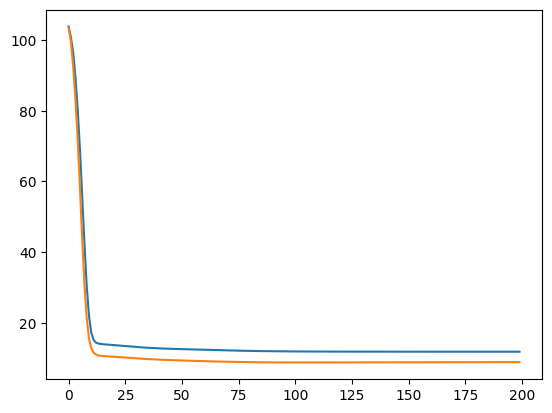

In [350]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [351]:
output_test = forward(x_test, NN)

Test loss:  9.786


<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\chens\AppData\Local\Temp\ipykernel_14672\1194488628.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{y}$");


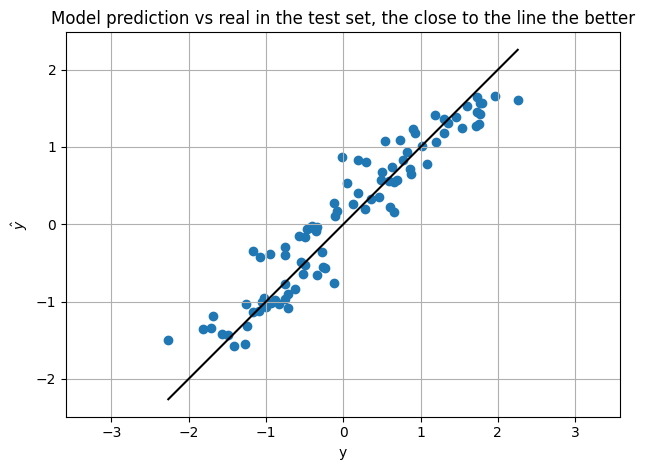

In [352]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

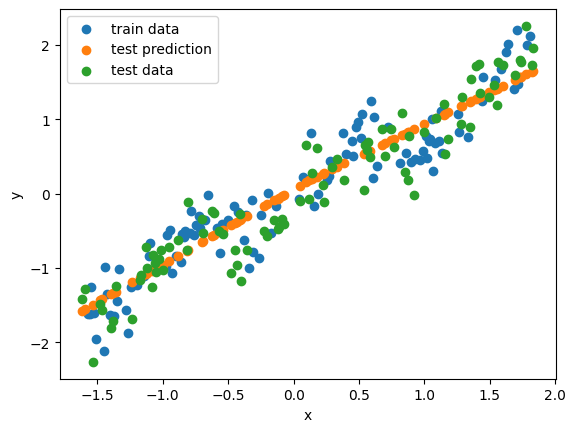

In [353]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._


<h2 style="color: white;">Solution l)</h2>

In order to show the case of overfitting, underfitting, and just right fitting, 3 networks will be proposed. There will be 1 input, 8 node hidden layer, and 1 output for all networks. Similar to the previous case, the relu and identity activation functions will be used. 

Here, the parameter will focus on the number of epochs that the model will go through during the training. 

1. For Underfitting : Train for too few epochs. The network will be trained through 10 epochs with a learning rate of 2e-6. This means the network will have very limited exposure to the data, likely leading to underfitting. In this case, both the training and test losses were high, indicating that the model did not learn the underlying patterns in the data well.

2. For Overfitting : Train for too many epochs. Even a well-balanced model can overfit if trained for too long. The network will undergo 200 epochs with a learning rate of 2e-5. As expected, the training loss should became extremely low, but the test loss would significantly higher. This is because the model memorized the training data, including noise, leading to poor generalization on new data. 

3. For just right fitting : Train with suitable epochs. Like the previous case, 50 epochs with a learning rate of 2e-3 will be used. Both training and test losses were low and close to each other, indicating good generalization.

Overall, the combination parameter of training epochs and learning rate could adjust fitting property of the network model, but there could be some other parameters such as weight initialization, activation functions, and network architecture. 

In [355]:
# Insert your code for getting overfitting, underfitting and just right fitting

params = [(10, 2e-6), (50,2e-3)]
NNs = []
train_losses = []
val_losses = []
for (EPOCHS, LEARN_R) in params:
  NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]
  train_loss = []
  val_loss = []
  for e in range(EPOCHS):
      
      # Forward pass and loss computation
      Loss = squared_loss(y_train, forward(x_train, NN))

      # Backward pass
      Loss.backward()
      
      # gradient descent update
      update_parameters(parameters(NN), LEARN_R)
      zero_gradients(parameters(NN))
      
      # Training loss
      train_loss.append(Loss.v)
      
      # Validation
      Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
      val_loss.append(Loss_validation.v)
      if e%10==0:
          print("{:4d}".format(e),
                "({:5.2f}%)".format(e/EPOCHS*100), 
                "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
  NNs.append(NN)
  train_losses.append(train_loss)
  val_losses.append(val_loss)

   0 ( 0.00%) Train loss: 105.245 	 Validation loss: 108.074
   0 ( 0.00%) Train loss: 105.064 	 Validation loss: 107.712
  10 (20.00%) Train loss: 104.325 	 Validation loss: 106.957
  20 (40.00%) Train loss: 100.729 	 Validation loss: 102.585
  30 (60.00%) Train loss: 50.563 	 Validation loss: 40.848
  40 (80.00%) Train loss: 15.053 	 Validation loss: 11.284


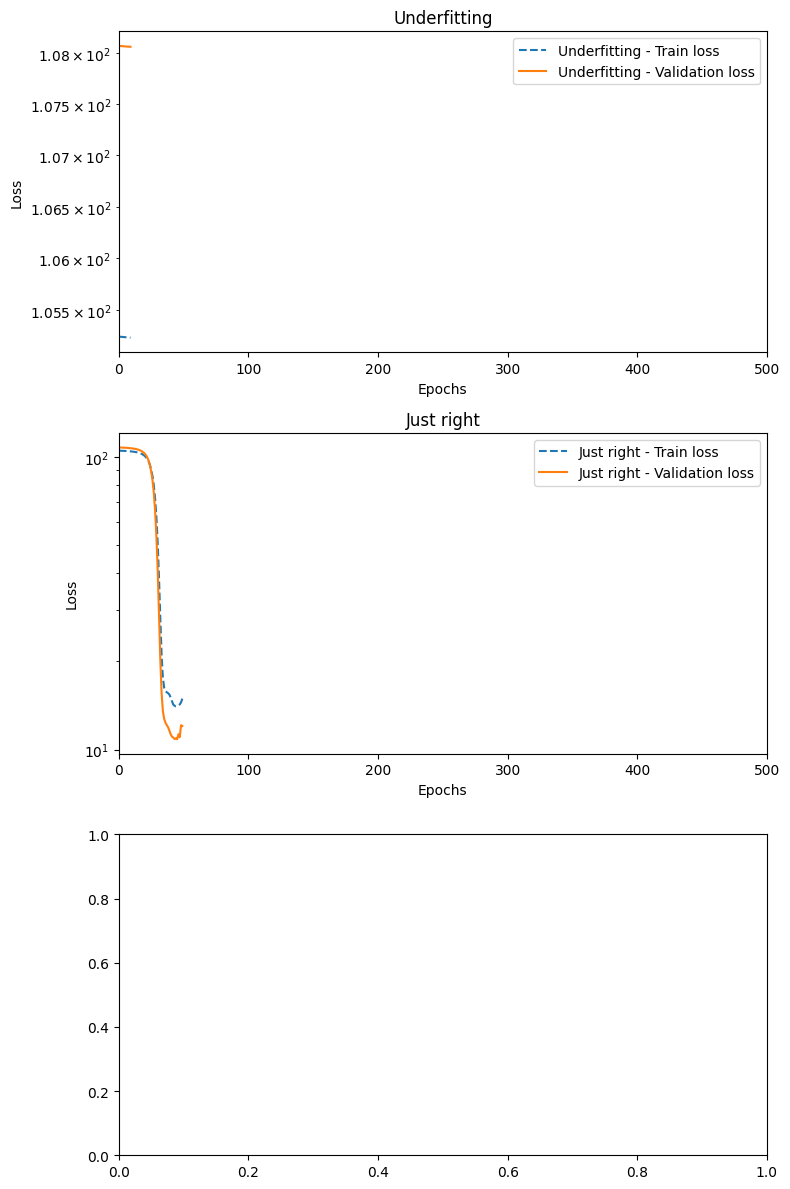

In [356]:
import matplotlib.pyplot as plt

types = ['Underfitting', 'Just right']
output_tests = []

# Assuming NNs, train_losses, val_losses, and types are already defined
# Create subplots for better visualization
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Create 3 subplots for each type

# Loop through the different networks and plot train and validation losses
for i in range(len(NNs)):
    output_tests.append(forward(x_test, NNs[i]))  # Forward pass for test set
    axs[i].plot(range(len(train_losses[i])), train_losses[i], label=f'{types[i]} - Train loss', linestyle='--')
    axs[i].plot(range(len(val_losses[i])), val_losses[i], label=f'{types[i]} - Validation loss', linestyle='-')
    
    # Set y-axis to logarithmic scale to better show differences
    axs[i].set_yscale('log')
    
    # Limit the x-axis to a reasonable number of epochs
    axs[i].set_xlim(0, 500)  # Adjust based on how many epochs are important for you to visualize
    
    # Labels and legends
    axs[i].legend()
    axs[i].set_title(f'{types[i]}')
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")

plt.tight_layout()
plt.show()


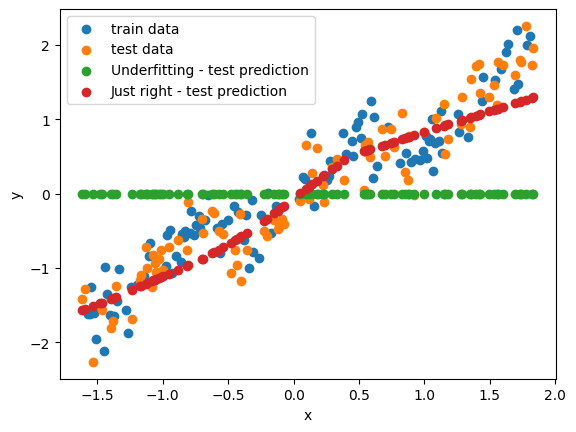

In [357]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, y_test_np, label="test data");
    for x in range(len(output_tests)):
      plt.scatter(x_test_np, Var_to_nparray(output_tests[x]), label=f"{types[x]} - test prediction");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    for x in range(len(output_tests)):
      plt.scatter(x_test_np[:,1], Var_to_nparray(output_tests[x]), label=f"{types[x]} - test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

In [358]:
for x in range(len(output_tests)):
  Lt = squared_loss(y_train, forward(x_train, NNs[x]))
  Lv = squared_loss(y_validation, forward(x_validation, NNs[x]))
  Lte = squared_loss(y_test, forward(x_test, NNs[x]))
  print(f'{types[x]}-model, train loss: {Lt.v}')
  print(f'{types[x]}-model, validation loss: {Lv.v}')
  print(f'{types[x]}-model, test loss:  {Lte.v}')

Underfitting-model, train loss: 105.2340766724558
Underfitting-model, validation loss: 108.06586413850661
Underfitting-model, test loss:  100.27657861942512
Just right-model, train loss: 15.679367424272959
Just right-model, validation loss: 12.029394937601438
Just right-model, test loss:  12.486875124132126


In [359]:
# Insert your code for getting overfitting, underfitting and just right fitting

params = [(200, 2e-5)]
NNs = []
train_losses = []
val_losses = []
for (EPOCHS, LEARN_R) in params:
  NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]
  train_loss = []
  val_loss = []
  for e in range(EPOCHS):
      
      # Forward pass and loss computation
      Loss = squared_loss(y_train[:10], forward(x_train[:10], NN))

      # Backward pass
      Loss.backward()
      
      # gradient descent update
      update_parameters(parameters(NN), LEARN_R)
      zero_gradients(parameters(NN))
      
      # Training loss
      train_loss.append(Loss.v)
      
      # Validation
      Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
      val_loss.append(Loss_validation.v)
      if e%10==0:
          print("{:4d}".format(e),
                "({:5.2f}%)".format(e/EPOCHS*100), 
                "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
  NNs.append(NN)
  train_losses.append(train_loss)
  val_losses.append(val_loss)

   0 ( 0.00%) Train loss: 10.074 	 Validation loss: 107.655
  10 ( 5.00%) Train loss: 10.071 	 Validation loss: 107.624
  20 (10.00%) Train loss: 10.068 	 Validation loss: 107.594
  30 (15.00%) Train loss: 10.066 	 Validation loss: 107.565
  40 (20.00%) Train loss: 10.063 	 Validation loss: 107.536
  50 (25.00%) Train loss: 10.061 	 Validation loss: 107.508
  60 (30.00%) Train loss: 10.058 	 Validation loss: 107.480
  70 (35.00%) Train loss: 10.056 	 Validation loss: 107.452
  80 (40.00%) Train loss: 10.053 	 Validation loss: 107.425
  90 (45.00%) Train loss: 10.051 	 Validation loss: 107.399
 100 (50.00%) Train loss: 10.048 	 Validation loss: 107.372
 110 (55.00%) Train loss: 10.046 	 Validation loss: 107.347
 120 (60.00%) Train loss: 10.044 	 Validation loss: 107.323
 130 (65.00%) Train loss: 10.042 	 Validation loss: 107.300
 140 (70.00%) Train loss: 10.040 	 Validation loss: 107.277
 150 (75.00%) Train loss: 10.038 	 Validation loss: 107.254
 160 (80.00%) Train loss: 10.036 	 Valid

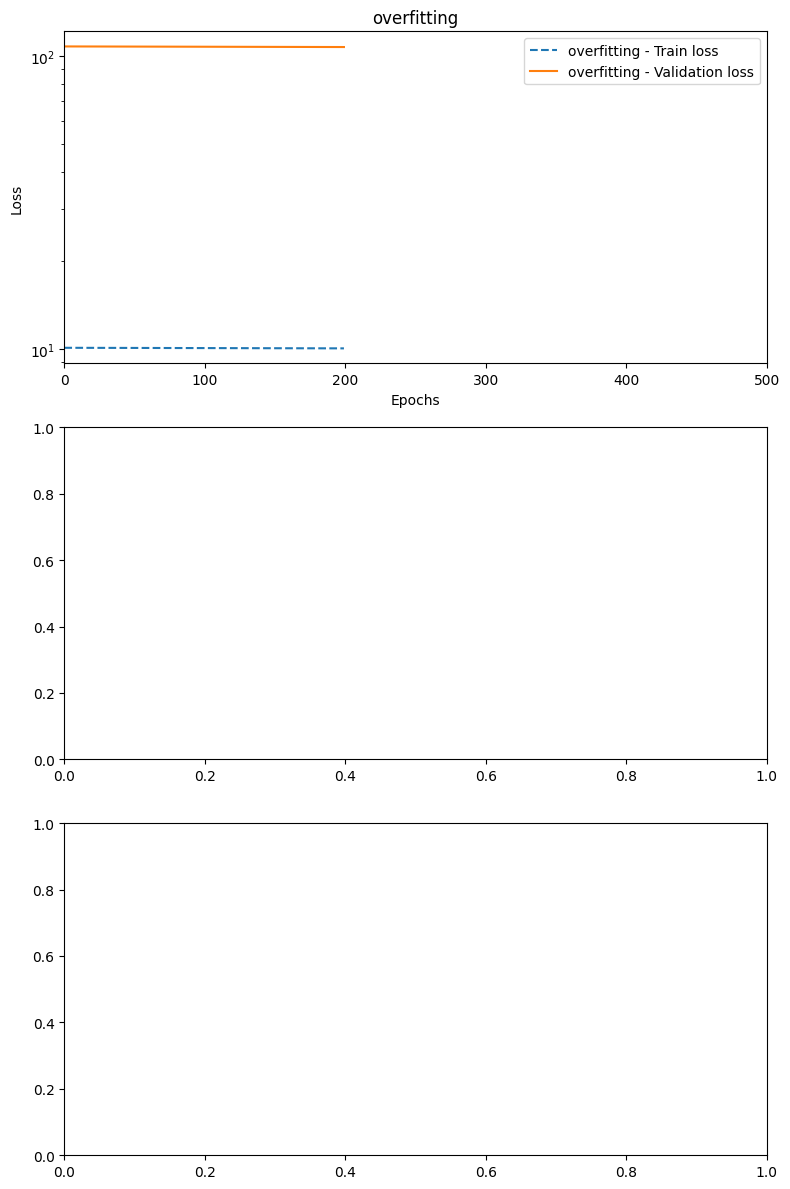

In [360]:
import matplotlib.pyplot as plt

types = ['overfitting']
output_tests = []

# Assuming NNs, train_losses, val_losses, and types are already defined
# Create subplots for better visualization
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Create 3 subplots for each type

# Loop through the different networks and plot train and validation losses
for i in range(len(NNs)):
    output_tests.append(forward(x_test, NNs[i]))  # Forward pass for test set
    axs[i].plot(range(len(train_losses[i])), train_losses[i], label=f'{types[i]} - Train loss', linestyle='--')
    axs[i].plot(range(len(val_losses[i])), val_losses[i], label=f'{types[i]} - Validation loss', linestyle='-')
    
    # Set y-axis to logarithmic scale to better show differences
    axs[i].set_yscale('log')
    
    # Limit the x-axis to a reasonable number of epochs
    axs[i].set_xlim(0, 500)  # Adjust based on how many epochs are important for you to visualize
    
    # Labels and legends
    axs[i].legend()
    axs[i].set_title(f'{types[i]}')
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")

plt.tight_layout()
plt.show()


# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [361]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [362]:
# just add some code